# CTGAN

In [1]:
import pandas as pd, numpy as np, warnings
warnings.filterwarnings('ignore')
cancer_data = pd.read_csv('data.csv')

cancer_data.drop(['id', 'Unnamed: 32'], axis=1, inplace = True)
cancer_data.replace({'diagnosis':{'M':1, 'B':0}}, inplace=True)


In [2]:
import sdv
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(cancer_data)

In [3]:
# single table CTGAN model

from sdv.single_table import CTGANSynthesizer
ctgan = CTGANSynthesizer(metadata=metadata)
ctgan.fit(cancer_data)
synthetic_data_ctgan = ctgan.sample(1000)

In [4]:
# diagnostic and quality check

from sdv.evaluation.single_table import evaluate_quality, run_diagnostic

diagnostic_report = run_diagnostic(cancer_data, synthetic_data_ctgan, metadata)
qulaity_report = evaluate_quality(cancer_data,synthetic_data_ctgan, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 2027.15it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 158.22it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 500.76it/s]|
Column Shapes Score: 75.2%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 240.93it/s]|
Column Pair Trends Score: 79.04%

Overall Score (Average): 77.12%



Computing intraset and contraset similarity scores

In [5]:
import gower 

# remove the target variable for gower distance calculation

X_real = cancer_data.drop('diagnosis', axis=1)
X_synth = synthetic_data_ctgan.drop('diagnosis', axis=1) 

# compute gower distance

gower_real = 1 - gower.gower_matrix(X_real)
gower_synth = 1 - gower.gower_matrix(X_synth)
gower_combined = 1 - gower.gower_matrix(pd.concat([X_real, X_synth], axis=0))

# upper triangle indices

real_upper = gower_real[np.triu_indices_from(gower_real, k=1)]
synth_upper = gower_synth[np.triu_indices_from(gower_synth, k=1)]

# Max and average intra-set similarity

max_intra_real = np.max(real_upper)
avg_intra_real = np.mean(real_upper)

max_intra_synth = np.max(synth_upper)
avg_intra_synth = np.mean(synth_upper)

# Flatten the cross-set matrix
cross_flat = gower_combined.flatten()

max_cross = np.max(cross_flat)
avg_cross = np.mean(cross_flat)

In [6]:
print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real:.4f}, Avg = {avg_intra_real:.4f}\n")

print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth:.4f}, Avg = {avg_intra_synth:.4f}\n")

print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross:.4f}, Avg = {avg_cross:.4f}")

Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9175, Avg = 0.8035

Cross-set Similarity (Real vs Synthetic):
Max = 1.0000, Avg = 0.8244


In [7]:
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics.pairwise import cosine_similarity

scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_ctgan.drop(columns=['diagnosis']))

# Cosine similarity
cross_sim = cosine_similarity(real_scaled, synthetic_scaled)
avg_sim = np.mean(cross_sim)
max_sim = np.max(cross_sim)

# MMD (using Gaussian kernel)
def gaussian_kernel(x, y, sigma=1.0):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    x_tile = np.tile(x, (y_size, 1))
    y_tile = np.repeat(y, x_size, axis=0)
    return np.exp(-np.sum((x_tile - y_tile)**2, axis=1) / (2 * dim * sigma**2)).reshape(y_size, x_size)

def compute_mmd(x, y, sigma=1.0):
    k_xx = np.mean(gaussian_kernel(x, x, sigma))
    k_yy = np.mean(gaussian_kernel(y, y, sigma))
    k_xy = np.mean(gaussian_kernel(x, y, sigma))
    return k_xx + k_yy - 2 * k_xy

mmd_score = compute_mmd(real_scaled, synthetic_scaled)

print(f"\n Sample-Level Similarity:")
print(f"Average cosine similarity: {avg_sim:.4f}")
print(f"Maximum cosine similarity: {max_sim:.4f}")
print(f"MMD score: {mmd_score:.4f}")


 Sample-Level Similarity:
Average cosine similarity: -0.0228
Maximum cosine similarity: 0.7123
MMD score: 0.1674


tSNE metrics

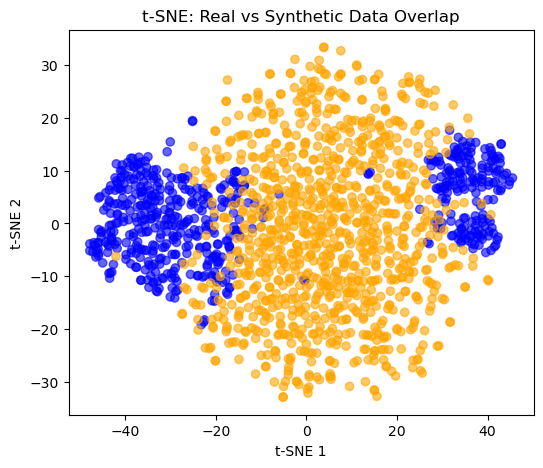

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
combined = np.vstack([real_scaled, synthetic_scaled])
tsne_result = tsne.fit_transform(combined)
labels = ['Real'] * len(real_scaled) + ['Synthetic'] * len(synthetic_scaled)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels],
            alpha=0.6, label=None)
plt.title("t-SNE: Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [9]:
# TSTR (Train on synthetic and test on real data)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define real and synthetic datasets
real_data = cancer_data
synthetic_data = synthetic_data_ctgan

# Split synthetic data (train/test)
X_synth = synthetic_data.drop(['diagnosis'], axis=1)
y_synth = synthetic_data['diagnosis']
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42
)

# Split real data (train/test)
X_real = real_data.drop(['diagnosis'], axis=1)
y_real = real_data['diagnosis']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Scale features using scaler fitted on synthetic training data
scaler = StandardScaler().fit(X_train_synth)
X_train_synth_scaled = scaler.transform(X_train_synth)
X_test_real_scaled = scaler.transform(X_test_real)  # scale real data with same scaler

# Train model on synthetic data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_synth_scaled, y_train_synth)

# Test model on real data
y_pred_real = model.predict(X_test_real_scaled)
y_pred_prob_real = model.predict_proba(X_test_real_scaled)[:, 1]  # probability for class 1

# Evaluate performance
acc = accuracy_score(y_test_real, y_pred_real)
f1 = f1_score(y_test_real, y_pred_real)
auc = roc_auc_score(y_test_real, y_pred_prob_real)

print("Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc:.3f}")
print(f"F1 Score = {f1:.3f}")
print(f"AUC = {auc:.3f}")

Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.868
F1 Score = 0.845
AUC = 0.980


In [10]:
# Privacy (Nearest Neighbor Distance)

from sklearn.neighbors import NearestNeighbors
# Standardize using the same scaler
scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_ctgan.drop(columns=['diagnosis']))

# Compute Nearest Neighbor Distance
nn = NearestNeighbors(n_neighbors=1).fit(real_scaled)
distances, _ = nn.kneighbors(synthetic_scaled)
avg_nn_dist = np.mean(distances)

print("Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist:.4f}")

Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 6.4042


In [11]:
from scipy.stats import wasserstein_distance

for col in cancer_data.columns:
    dist = wasserstein_distance(cancer_data[col], synthetic_data_ctgan[col])
    print(f'{col}: {dist: .4f}')

diagnosis:  0.1064
radius_mean:  2.0506
texture_mean:  1.5171
perimeter_mean:  13.9280
area_mean:  227.8710
smoothness_mean:  0.0072
compactness_mean:  0.0479
concavity_mean:  0.0444
concave points_mean:  0.0198
symmetry_mean:  0.0245
fractal_dimension_mean:  0.0019
radius_se:  0.0426
texture_se:  0.3648
perimeter_se:  0.7165
area_se:  5.8568
smoothness_se:  0.0036
compactness_se:  0.0083
concavity_se:  0.0148
concave points_se:  0.0041
symmetry_se:  0.0083
fractal_dimension_se:  0.0008
radius_worst:  2.1457
texture_worst:  1.0979
perimeter_worst:  23.6360
area_worst:  151.7787
smoothness_worst:  0.0150
compactness_worst:  0.0571
concavity_worst:  0.1153
concave points_worst:  0.0211
symmetry_worst:  0.0560
fractal_dimension_worst:  0.0023


In [12]:
from sdv.evaluation.single_table import QualityReport

# 1. Initialize report
quality_report = QualityReport()

# 2. Generate with metadata converted to dict
quality_report.generate(
    real_data=cancer_data,
    synthetic_data=synthetic_data_ctgan,
    metadata=metadata.to_dict()  
)

# 3. Get details
details = quality_report.get_details('Column Shapes')
print(details)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 441.55it/s]|
Column Shapes Score: 75.2%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 331.85it/s]|
Column Pair Trends Score: 79.04%

Overall Score (Average): 77.12%

                     Column        Metric     Score
0                 diagnosis  TVComplement  0.893583
1               radius_mean  KSComplement  0.713005
2              texture_mean  KSComplement  0.848554
3            perimeter_mean  KSComplement  0.701112
4                 area_mean  KSComplement  0.656763
5           smoothness_mean  KSComplement  0.761531
6          compactness_mean  KSComplement  0.658169
7            concavity_mean  KSComplement  0.777420
8       concave points_mean  KSComplement  0.720091
9             symmetry_mean  KSComplement  0.635504
10   fractal_dimension_mean  KSComplement  0.890288
11                radius_se  KSComplement  0.911814
12               texture_se  KSComplement  

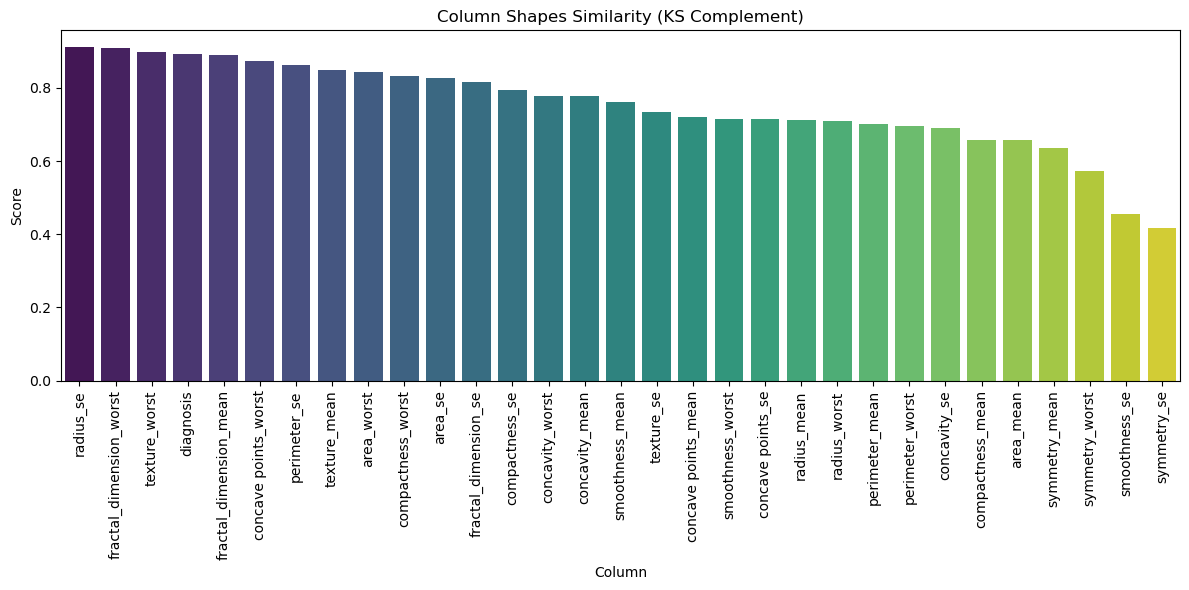

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    x='Column', y='Score',
    data=details.sort_values('Score', ascending=False),
    palette='viridis'
)
plt.title('Column Shapes Similarity (KS Complement)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

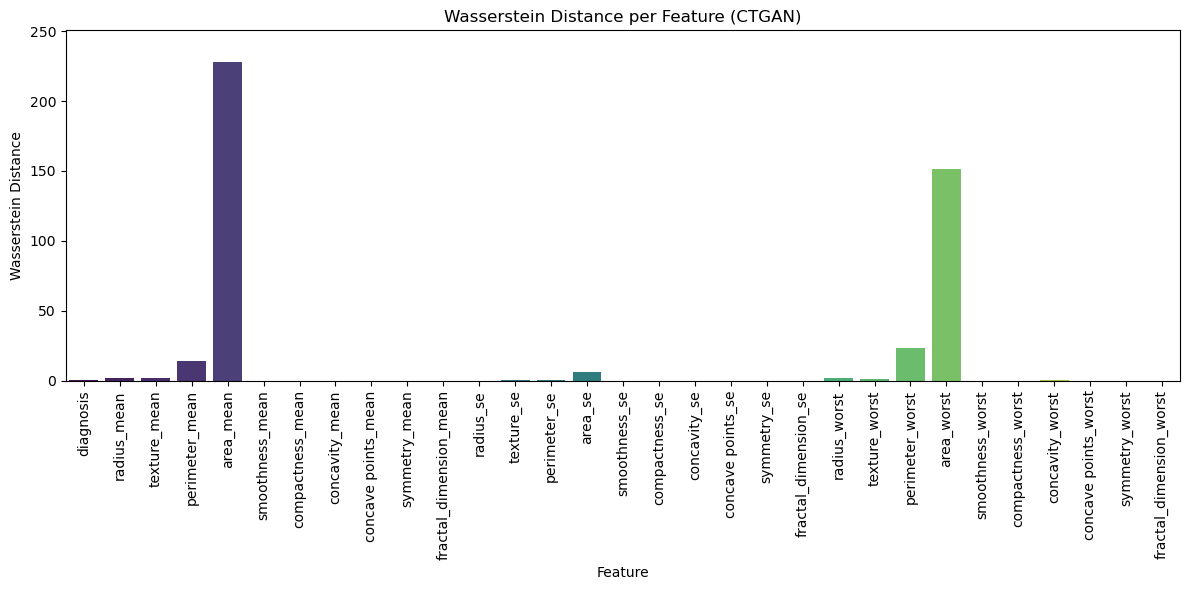

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wasserstein_distance

# Compute distances
distances = {col: wasserstein_distance(cancer_data[col], synthetic_data_ctgan[col]) 
             for col in cancer_data.columns}
dist_df = pd.DataFrame(list(distances.items()), columns=['Feature', 'Wasserstein Distance'])

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y='Wasserstein Distance', data=dist_df, palette='viridis')

# Format axes
plt.xticks(rotation=90)
plt.title('Wasserstein Distance per Feature (CTGAN)')
plt.tight_layout()

# Adjust y-axis to fit data better
ymin = 0
ymax = dist_df['Wasserstein Distance'].max() * 1.1  # add 10% padding on top
plt.ylim(ymin, ymax)

plt.show()

In [43]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, ks_2samp, wasserstein_distance, chi2_contingency

# ---------- helpers ----------
def _prob_vectors_numeric(real, synth, bins=30, eps=1e-12):
    real = pd.to_numeric(real, errors='coerce').dropna().to_numpy()
    synth = pd.to_numeric(synth, errors='coerce').dropna().to_numpy()
    edges = np.histogram_bin_edges(np.concatenate([real, synth]), bins=bins)
    r_hist, _ = np.histogram(real,  bins=edges)
    s_hist, _ = np.histogram(synth, bins=edges)
    r = r_hist.astype(float) + eps
    s = s_hist.astype(float) + eps
    r /= r.sum(); s /= s.sum()
    return r, s

def _prob_vectors_categorical(real, synth, eps=1e-12):
    r_counts = real.astype("object").value_counts(dropna=False)
    s_counts = synth.astype("object").value_counts(dropna=False)
    keys = r_counts.index.union(s_counts.index)
    r = r_counts.reindex(keys, fill_value=0).to_numpy(dtype=float) + eps
    s = s_counts.reindex(keys, fill_value=0).to_numpy(dtype=float) + eps
    r /= r.sum(); s /= s.sum()
    return r, s, keys

def _js_kl(p, q, base=2):
    js_dist = jensenshannon(p, q, base=base)
    js_div = js_dist ** 2
    kl_pq = entropy(p, q, base=base)  # KL(P||Q)
    kl_qp = entropy(q, p, base=base)  # KL(Q||P)
    return js_div, js_dist, kl_pq, kl_qp

# ---------- main ----------
def evaluate_all_metrics(real_df: pd.DataFrame,
                         synth_df: pd.DataFrame,
                         bins="fd", base=2, eps=1e-12) -> pd.DataFrame:
    """
    Returns per-column JS, KL, KS, Wasserstein (+ TVD & Chi2 for categoricals).
    P = real, Q = synthetic.
    """
    cols = [c for c in real_df.columns if c in synth_df.columns]
    rows = []

    for col in cols:
        r_col = real_df[col]
        s_col = synth_df[col]

        if is_numeric_dtype(r_col) and is_numeric_dtype(s_col):
            # numeric: use histograms for JS/KL; direct KS & Wasserstein
            p, q = _prob_vectors_numeric(r_col, s_col, bins=bins, eps=eps)
            js_div, js_dist, kl_pq, kl_qp = _js_kl(p, q, base=base)

            # KS & Wasserstein
            r_vals = pd.to_numeric(r_col, errors='coerce').dropna().to_numpy()
            s_vals = pd.to_numeric(s_col, errors='coerce').dropna().to_numpy()
            ks_stat, ks_p = ks_2samp(r_vals, s_vals, alternative='two-sided', mode='auto')
            wdist = wasserstein_distance(r_vals, s_vals)

            rows.append({
                "Feature": col, "Type": "numeric",
                "JS_divergence": js_div, "JS_distance": js_dist,
                "KL_real||synthetic": kl_pq, "KL_synthetic||real": kl_qp,
                "KS_statistic": ks_stat, "KS_pvalue": ks_p,
                "Wasserstein": wdist,
                "TVD": np.nan, "Chi2_stat": np.nan, "Chi2_pvalue": np.nan
            })

        else:
            # categorical: align categories; JS/KL; TVD; Chi-square test
            p, q, keys = _prob_vectors_categorical(r_col, s_col, eps=eps)
            js_div, js_dist, kl_pq, kl_qp = _js_kl(p, q, base=base)
            tvd = 0.5 * np.abs(p - q).sum()

            # build 2xK contingency table with *counts* (not probabilities)
            r_counts = r_col.astype("object").value_counts(dropna=False).reindex(keys, fill_value=0).to_numpy()
            s_counts = s_col.astype("object").value_counts(dropna=False).reindex(keys, fill_value=0).to_numpy()
            chi2, chi2_p, dof, _ = chi2_contingency(np.vstack([r_counts, s_counts]), correction=False)

            rows.append({
                "Feature": col, "Type": "categorical",
                "JS_divergence": js_div, "JS_distance": js_dist,
                "KL_real||synthetic": kl_pq, "KL_synthetic||real": kl_qp,
                "KS_statistic": np.nan, "KS_pvalue": np.nan,
                "Wasserstein": np.nan,
                "TVD": tvd, "Chi2_stat": chi2, "Chi2_pvalue": chi2_p
            })

    return pd.DataFrame(rows).sort_values(["Type", "JS_divergence", "Feature"]).reset_index(drop=True)

# ---- usage example ----
results = evaluate_all_metrics(cancer_data, synthetic_data_ctgan, bins="fd")
print(results)
# results.describe()


                    Feature     Type  JS_divergence  JS_distance  \
0                 diagnosis  numeric       0.008371     0.091491   
1             texture_worst  numeric       0.030777     0.175435   
2              texture_mean  numeric       0.042913     0.207155   
3                 radius_se  numeric       0.045098     0.212362   
4      concave points_worst  numeric       0.045494     0.213294   
5              perimeter_se  numeric       0.047264     0.217403   
6   fractal_dimension_worst  numeric       0.047403     0.217722   
7    fractal_dimension_mean  numeric       0.048628     0.220517   
8         compactness_worst  numeric       0.059223     0.243359   
9           concavity_worst  numeric       0.059252     0.243417   
10          smoothness_mean  numeric       0.069466     0.263563   
11           compactness_se  numeric       0.069711     0.264028   
12               area_worst  numeric       0.070437     0.265400   
13           concavity_mean  numeric       0.080

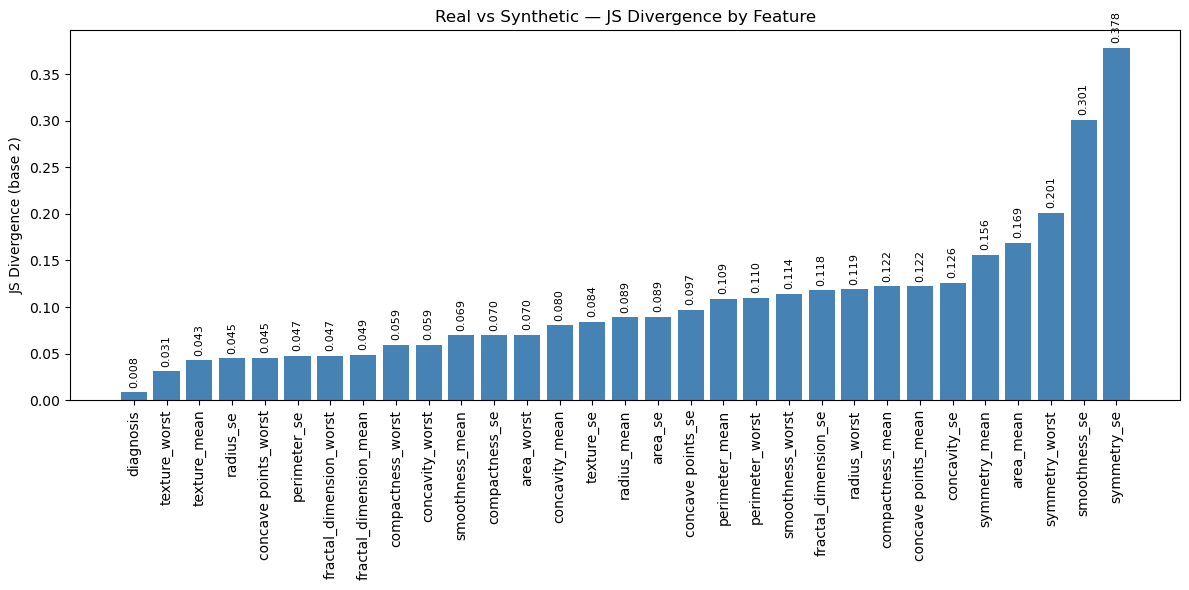

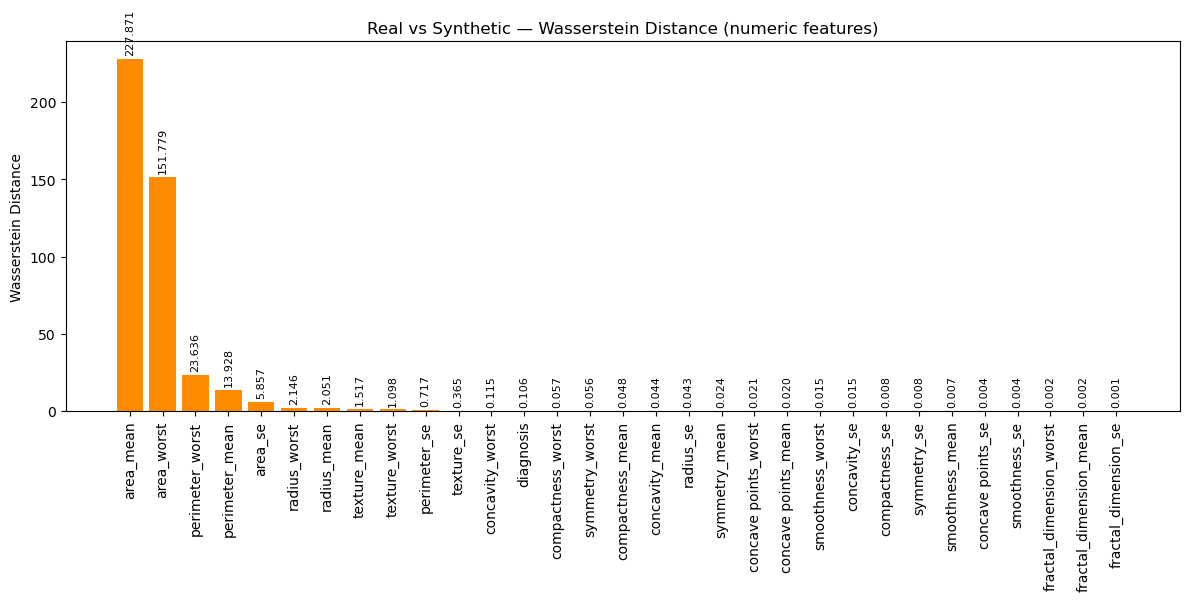

In [44]:
import matplotlib.pyplot as plt

res = evaluate_all_metrics(cancer_data, synthetic_data_ctgan, bins="fd")

# --- JS Divergence by Feature ---
plt.figure(figsize=(12,6))
bars = plt.bar(res["Feature"], res["JS_divergence"], color='steelblue')
plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("Real vs Synthetic — JS Divergence by Feature")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.005,                      # vertical offset
        f"{yval:.3f}", 
        ha='center', va='bottom', fontsize=8, rotation=90
    )

plt.show()


# --- Numeric-only Wasserstein ---
num_res = res[res["Type"] == "numeric"].sort_values("Wasserstein", ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(num_res["Feature"], num_res["Wasserstein"], color='darkorange')
plt.xticks(rotation=90)
plt.ylabel("Wasserstein Distance")
plt.title("Real vs Synthetic — Wasserstein Distance (numeric features)")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + (num_res["Wasserstein"].max() * 0.01),  # small offset based on scale
        f"{yval:.3f}", 
        ha='center', va='bottom', fontsize=8, rotation=90
    )

plt.show()

# CopulaGAN


CopulaGAN is a GAN-based synthetic data generator for tabular data that uses copulas to better model dependencies between features.

GAN component: Learns the overall data distribution and generates synthetic samples.

Copula component: Models dependence structure between columns, especially useful for non-Gaussian or skewed distributions.

In [17]:
import pandas as pd, numpy as np, warnings
warnings.filterwarnings('ignore')
cancer_data = pd.read_csv('data.csv')

cancer_data.drop(['id', 'Unnamed: 32'], axis=1, inplace = True)
cancer_data.replace({'diagnosis':{'M':1, 'B':0}}, inplace=True)

import sdv
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(cancer_data)

from sdv.single_table import CopulaGANSynthesizer
copulagan= CopulaGANSynthesizer(metadata)
copulagan.fit(cancer_data)
synthetic_data_copulagan = copulagan.sample(1000)

In [18]:
# diagnostic check and quality check

from sdv.evaluation.single_table import evaluate_quality, run_diagnostic

diagnostic_report = run_diagnostic(cancer_data, synthetic_data_copulagan, metadata) 
quality_report = evaluate_quality(cancer_data, synthetic_data_copulagan, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 2335.36it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 211.20it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 732.53it/s]|
Column Shapes Score: 71.83%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 382.00it/s]|
Column Pair Trends Score: 79.3%

Overall Score (Average): 75.56%



In [19]:
import gower

real_data = cancer_data
synthetic_data = synthetic_data_copulagan

# Remove target column
X_real = real_data.drop(columns=['diagnosis'])
X_synth = synthetic_data.drop(columns=['diagnosis'])

# Compute Gower distance matrices
gower_real = 1 - gower.gower_matrix(X_real)    # similarity = 1 - distance
gower_synth = 1 - gower.gower_matrix(X_synth)
gower_cross = 1 - gower.gower_matrix(X_real, X_synth)  # cross-set similarity


# Upper triangle indices (exclude diagonal)

real_upper = gower_real[np.triu_indices_from(gower_real, k=1)]
synth_upper = gower_synth[np.triu_indices_from(gower_synth, k=1)]

# Max and average intra-set similarity

max_intra_real = np.max(real_upper)
avg_intra_real = np.mean(real_upper)

max_intra_synth = np.max(synth_upper)
avg_intra_synth = np.mean(synth_upper)

# Flatten the cross-set matrix

cross_flat = gower_cross.flatten()

max_cross = np.max(cross_flat)
avg_cross = np.mean(cross_flat)


print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real:.4f}, Avg = {avg_intra_real:.4f}\n")

print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth:.4f}, Avg = {avg_intra_synth:.4f}\n")

print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross:.4f}, Avg = {avg_cross:.4f}")

Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9254, Avg = 0.7998

Cross-set Similarity (Real vs Synthetic):
Max = 0.9382, Avg = 0.8156


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_copulagan.drop(columns=['diagnosis']))

# Cosine similarity
cross_sim = cosine_similarity(real_scaled, synthetic_scaled)
avg_sim = np.mean(cross_sim)
max_sim = np.max(cross_sim)

# MMD (using Gaussian kernel)
def gaussian_kernel(x, y, sigma=1.0):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    x_tile = np.tile(x, (y_size, 1))
    y_tile = np.repeat(y, x_size, axis=0)
    return np.exp(-np.sum((x_tile - y_tile)**2, axis=1) / (2 * dim * sigma**2)).reshape(y_size, x_size)

def compute_mmd(x, y, sigma=1.0):
    k_xx = np.mean(gaussian_kernel(x, x, sigma))
    k_yy = np.mean(gaussian_kernel(y, y, sigma))
    k_xy = np.mean(gaussian_kernel(x, y, sigma))
    return k_xx + k_yy - 2 * k_xy

mmd_score = compute_mmd(real_scaled, synthetic_scaled)

print(f"\n Sample-Level Similarity:")
print(f"Average cosine similarity: {avg_sim:.4f}")
print(f"Maximum cosine similarity: {max_sim:.4f}")
print(f"MMD score: {mmd_score:.4f}")


 Sample-Level Similarity:
Average cosine similarity: -0.0105
Maximum cosine similarity: 0.7720
MMD score: 0.1918


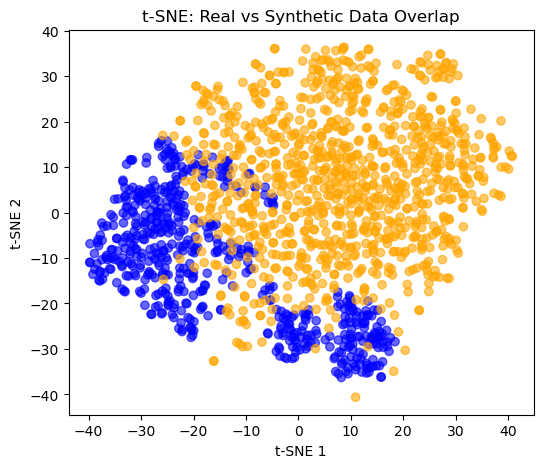

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
combined = np.vstack([real_scaled, synthetic_scaled])
tsne_result = tsne.fit_transform(combined)
labels = ['Real'] * len(real_scaled) + ['Synthetic'] * len(synthetic_scaled)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels],
            alpha=0.6, label=None)
plt.title("t-SNE: Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# # Define real and synthetic datasets
real_data = cancer_data
synthetic_data = synthetic_data_copulagan

# Split synthetic data (train/test)
X_synth = synthetic_data.drop(['diagnosis'], axis=1)
y_synth = synthetic_data['diagnosis']
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42
)

# Split real data (train/test)
X_real = cancer_data.drop(['diagnosis'], axis=1)
y_real =  cancer_data['diagnosis']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Scale features using scaler fitted on synthetic training data
scaler = StandardScaler().fit(X_train_synth)
X_train_synth_scaled = scaler.transform(X_train_synth)
X_test_real_scaled = scaler.transform(X_test_real)  # scale real data with same scaler

# Train model on synthetic data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_synth_scaled, y_train_synth)

# Test model on real data
y_pred_real = model.predict(X_test_real_scaled)
y_pred_prob_real = model.predict_proba(X_test_real_scaled)[:, 1]  # probability for class 1

# Evaluate performance
acc = accuracy_score(y_test_real, y_pred_real)
f1 = f1_score(y_test_real, y_pred_real)
auc = roc_auc_score(y_test_real, y_pred_prob_real)

print("Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc:.3f}")
print(f"F1 Score = {f1:.3f}")
print(f"AUC = {auc:.3f}")

Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.623
F1 Score = 0.246
AUC = 0.554


In [23]:
# Privacy (Nearest Neighbor Distance)

from sklearn.neighbors import NearestNeighbors
# Standardize using the same scaler
scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_copulagan.drop(columns=['diagnosis']))

# Compute Nearest Neighbor Distance
nn = NearestNeighbors(n_neighbors=1).fit(real_scaled)
distances, _ = nn.kneighbors(synthetic_scaled)
avg_nn_dist = np.mean(distances)

print("Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist:.4f}")

Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 6.7721


diagnosis:  0.1084
radius_mean:  4.4747
texture_mean:  3.2631
perimeter_mean:  6.6542
area_mean:  565.2861
smoothness_mean:  0.0049
compactness_mean:  0.0092
concavity_mean:  0.0131
concave points_mean:  0.0110
symmetry_mean:  0.0080
fractal_dimension_mean:  0.0020
radius_se:  0.0902
texture_se:  0.3234
perimeter_se:  0.5462
area_se:  32.1723
smoothness_se:  0.0017
compactness_se:  0.0090
concavity_se:  0.0046
concave points_se:  0.0030
symmetry_se:  0.0045
fractal_dimension_se:  0.0025
radius_worst:  6.7033
texture_worst:  2.0973
perimeter_worst:  36.3622
area_worst:  413.0021
smoothness_worst:  0.0163
compactness_worst:  0.1027
concavity_worst:  0.1460
concave points_worst:  0.0213
symmetry_worst:  0.0403
fractal_dimension_worst:  0.0106


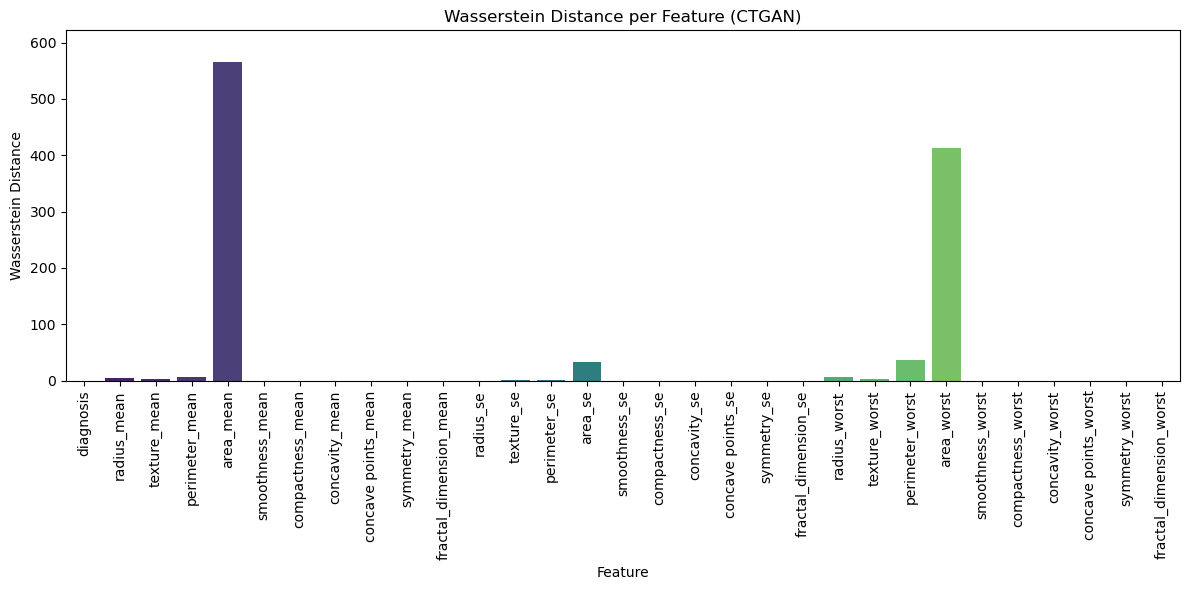

In [24]:
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt


for col in cancer_data.columns:
    dist = wasserstein_distance(cancer_data[col], synthetic_data_copulagan[col])
    print(f'{col}: {dist: .4f}')


# Compute distances
distances = {col: wasserstein_distance(cancer_data[col], synthetic_data_copulagan[col]) 
             for col in cancer_data.columns}
dist_df = pd.DataFrame(list(distances.items()), columns=['Feature', 'Wasserstein Distance'])

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y='Wasserstein Distance', data=dist_df, palette='viridis')

# Format axes
plt.xticks(rotation=90)
plt.title('Wasserstein Distance per Feature (CTGAN)')
plt.tight_layout()

# Adjust y-axis to fit data better
ymin = 0
ymax = dist_df['Wasserstein Distance'].max() * 1.1  # add 10% padding on top
plt.ylim(ymin, ymax)

plt.show()

In [42]:
# ---- usage example ----
results = evaluate_all_metrics(cancer_data, synthetic_data_copulagan, bins="fd")
print(results)
# results.describe()


                    Feature     Type  JS_divergence  JS_distance  \
0                 diagnosis  numeric       0.008684     0.093186   
1          compactness_mean  numeric       0.030705     0.175228   
2            concavity_mean  numeric       0.037129     0.192688   
3              concavity_se  numeric       0.040769     0.201914   
4             symmetry_mean  numeric       0.040842     0.202095   
5             texture_worst  numeric       0.041863     0.204604   
6           smoothness_mean  numeric       0.048398     0.219996   
7            perimeter_mean  numeric       0.057567     0.239931   
8      concave points_worst  numeric       0.058256     0.241363   
9         compactness_worst  numeric       0.059044     0.242989   
10   fractal_dimension_mean  numeric       0.062272     0.249543   
11      concave points_mean  numeric       0.071635     0.267647   
12          concavity_worst  numeric       0.087292     0.295452   
13             texture_mean  numeric       0.095

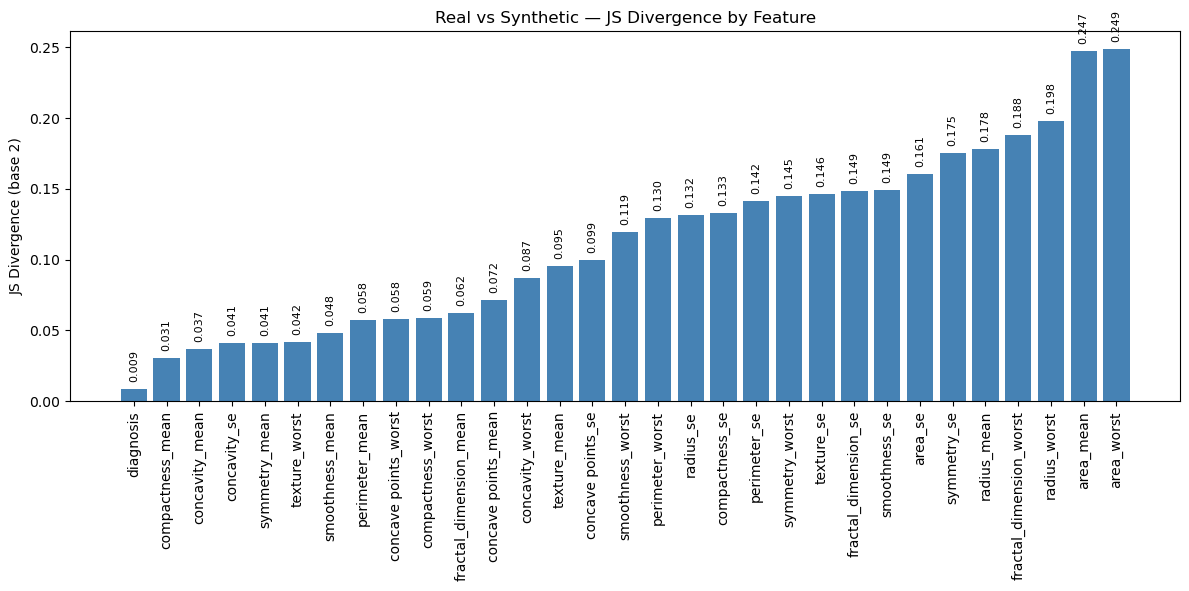

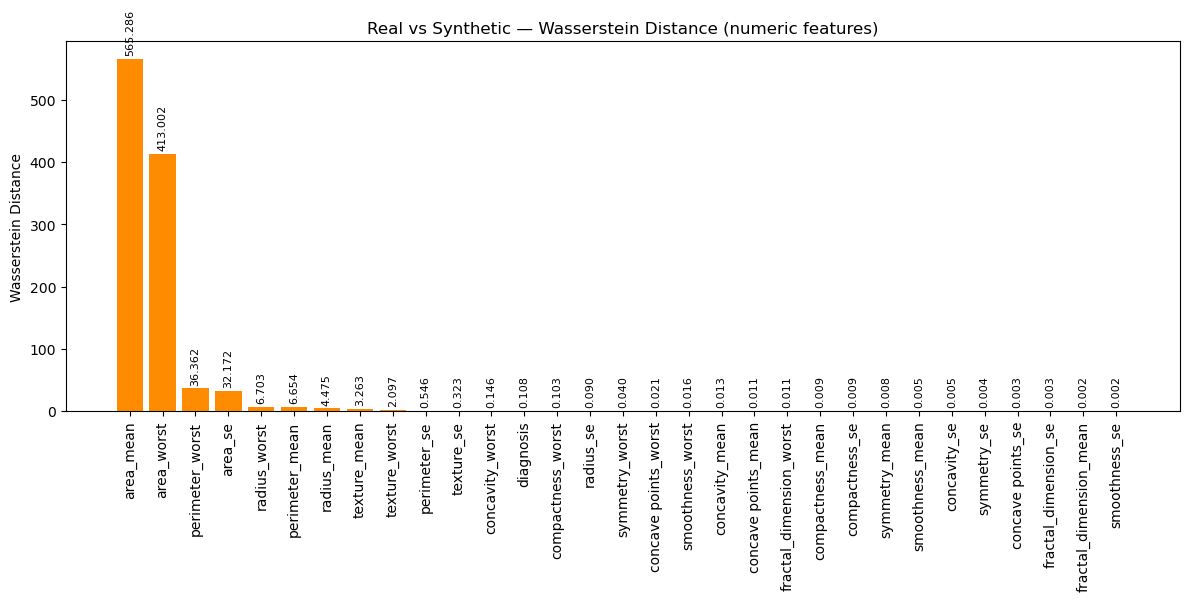

In [45]:
import matplotlib.pyplot as plt

res = evaluate_all_metrics(cancer_data, synthetic_data_copulagan, bins="fd")

# --- JS Divergence by Feature ---
plt.figure(figsize=(12,6))
bars = plt.bar(res["Feature"], res["JS_divergence"], color='steelblue')
plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("Real vs Synthetic — JS Divergence by Feature")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.005,                      # vertical offset
        f"{yval:.3f}", 
        ha='center', va='bottom', fontsize=8, rotation=90
    )

plt.show()


# --- Numeric-only Wasserstein ---
num_res = res[res["Type"] == "numeric"].sort_values("Wasserstein", ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(num_res["Feature"], num_res["Wasserstein"], color='darkorange')
plt.xticks(rotation=90)
plt.ylabel("Wasserstein Distance")
plt.title("Real vs Synthetic — Wasserstein Distance (numeric features)")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + (num_res["Wasserstein"].max() * 0.01),  # small offset based on scale
        f"{yval:.3f}", 
        ha='center', va='bottom', fontsize=8, rotation=90
    )

plt.show()

# Gaussian Copula

The **Gaussian Copula** is a statistical model used to generate synthetic data by capturing the dependencies among variables while allowing each feature to maintain its own marginal distribution. It works by transforming the original data into a multivariate normal space, modeling the correlations between features using a Gaussian distribution, and then mapping the data back to the original feature scales. This approach preserves both linear and certain nonlinear relationships between variables, making it particularly effective for tabular datasets like the Breast Cancer Wisconsin dataset. By leveraging the Gaussian Copula, synthetic data can closely approximate the joint distribution of real data while maintaining flexibility, interpretability, and privacy protection.


In [26]:
from sdv.single_table import GaussianCopulaSynthesizer
gaussiancopula = GaussianCopulaSynthesizer(metadata)
gaussiancopula.fit(cancer_data)
synthetic_data_gaussiancopula = gaussiancopula.sample(num_rows=1000)
diagnostic_report = run_diagnostic(cancer_data, synthetic_data_gaussiancopula, metadata)
quality_report = evaluate_quality(cancer_data, synthetic_data_gaussiancopula, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 3847.42it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<?, ?it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 932.88it/s]|
Column Shapes Score: 93.0%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 264.91it/s]|
Column Pair Trends Score: 95.75%

Overall Score (Average): 94.37%



In [27]:
# Remove target column
X_real = cancer_data.drop(columns=['diagnosis'])
X_synth = synthetic_data_gaussiancopula.drop(columns=['diagnosis'])

# Compute Gower distance matrices
gower_real = 1 - gower.gower_matrix(X_real)    # similarity = 1 - distance
gower_synth = 1 - gower.gower_matrix(X_synth)
gower_cross = 1 - gower.gower_matrix(X_real, X_synth)  # cross-set similarity


# Upper triangle indices (exclude diagonal)

real_upper = gower_real[np.triu_indices_from(gower_real, k=1)]
synth_upper = gower_synth[np.triu_indices_from(gower_synth, k=1)]

# Max and average intra-set similarity

max_intra_real = np.max(real_upper)
avg_intra_real = np.mean(real_upper)

max_intra_synth = np.max(synth_upper)
avg_intra_synth = np.mean(synth_upper)

# Flatten the cross-set matrix

cross_flat = gower_cross.flatten()

max_cross = np.max(cross_flat)
avg_cross = np.mean(cross_flat)


print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real:.4f}, Avg = {avg_intra_real:.4f}\n")

print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth:.4f}, Avg = {avg_intra_synth:.4f}\n")

print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross:.4f}, Avg = {avg_cross:.4f}")

Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9787, Avg = 0.8238

Cross-set Similarity (Real vs Synthetic):
Max = 0.9820, Avg = 0.8519


In [28]:
from sklearn.metrics.pairwise import cosine_similarity

scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_gaussiancopula.drop(columns=['diagnosis']))

# Cosine similarity
cross_sim = cosine_similarity(real_scaled, synthetic_scaled)
avg_sim = np.mean(cross_sim)
max_sim = np.max(cross_sim)

# MMD (using Gaussian kernel)
def gaussian_kernel(x, y, sigma=1.0):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    x_tile = np.tile(x, (y_size, 1))
    y_tile = np.repeat(y, x_size, axis=0)
    return np.exp(-np.sum((x_tile - y_tile)**2, axis=1) / (2 * dim * sigma**2)).reshape(y_size, x_size)

def compute_mmd(x, y, sigma=1.0):
    k_xx = np.mean(gaussian_kernel(x, x, sigma))
    k_yy = np.mean(gaussian_kernel(y, y, sigma))
    k_xy = np.mean(gaussian_kernel(x, y, sigma))
    return k_xx + k_yy - 2 * k_xy

mmd_score = compute_mmd(real_scaled, synthetic_scaled)

print(f"\n Sample-Level Similarity:")
print(f"Average cosine similarity: {avg_sim:.4f}")
print(f"Maximum cosine similarity: {max_sim:.4f}")
print(f"MMD score: {mmd_score:.4f}")


 Sample-Level Similarity:
Average cosine similarity: 0.0128
Maximum cosine similarity: 0.9734
MMD score: 0.0039


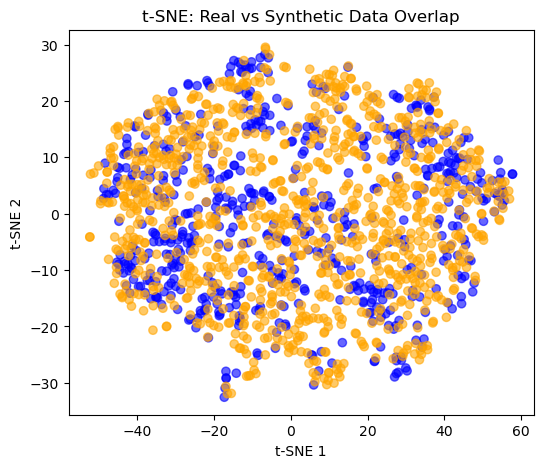

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
combined = np.vstack([real_scaled, synthetic_scaled])
tsne_result = tsne.fit_transform(combined)
labels = ['Real'] * len(real_scaled) + ['Synthetic'] * len(synthetic_scaled)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels],
            alpha=0.6, label=None)
plt.title("t-SNE: Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define real and synthetic datasets
real_data = cancer_data
synthetic_data = synthetic_data_gaussiancopula

# Split synthetic data (train/test)
X_synth = synthetic_data.drop(['diagnosis'], axis=1)
y_synth = synthetic_data['diagnosis']
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42
)

# Split real data (train/test)
X_real = real_data.drop(['diagnosis'], axis=1)
y_real = real_data['diagnosis']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Scale features using scaler fitted on synthetic training data
scaler = StandardScaler().fit(X_train_synth)
X_train_synth_scaled = scaler.transform(X_train_synth)
X_test_real_scaled = scaler.transform(X_test_real)  # scale real data with same scaler

# Train model on synthetic data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_synth_scaled, y_train_synth)

# Test model on real data
y_pred_real = model.predict(X_test_real_scaled)
y_pred_prob_real = model.predict_proba(X_test_real_scaled)[:, 1]  # probability for class 1

# Evaluate performance
acc = accuracy_score(y_test_real, y_pred_real)
f1 = f1_score(y_test_real, y_pred_real)
auc = roc_auc_score(y_test_real, y_pred_prob_real)

print("Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc:.3f}")
print(f"F1 Score = {f1:.3f}")
print(f"AUC = {auc:.3f}")

Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.930
F1 Score = 0.897
AUC = 0.988


In [31]:
# Privacy (Nearest Neighbor Distance)

from sklearn.neighbors import NearestNeighbors

# Standardize using the same scaler
scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_gaussiancopula.drop(columns=['diagnosis']))

# Compute Nearest Neighbor Distance
nn = NearestNeighbors(n_neighbors=1).fit(real_scaled)
distances, _ = nn.kneighbors(synthetic_scaled)
avg_nn_dist = np.mean(distances)

print("Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist:.4f}")

Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 2.7229


diagnosis:  0.1084
radius_mean:  4.4747
texture_mean:  3.2631
perimeter_mean:  6.6542
area_mean:  565.2861
smoothness_mean:  0.0049
compactness_mean:  0.0092
concavity_mean:  0.0131
concave points_mean:  0.0110
symmetry_mean:  0.0080
fractal_dimension_mean:  0.0020
radius_se:  0.0902
texture_se:  0.3234
perimeter_se:  0.5462
area_se:  32.1723
smoothness_se:  0.0017
compactness_se:  0.0090
concavity_se:  0.0046
concave points_se:  0.0030
symmetry_se:  0.0045
fractal_dimension_se:  0.0025
radius_worst:  6.7033
texture_worst:  2.0973
perimeter_worst:  36.3622
area_worst:  413.0021
smoothness_worst:  0.0163
compactness_worst:  0.1027
concavity_worst:  0.1460
concave points_worst:  0.0213
symmetry_worst:  0.0403
fractal_dimension_worst:  0.0106


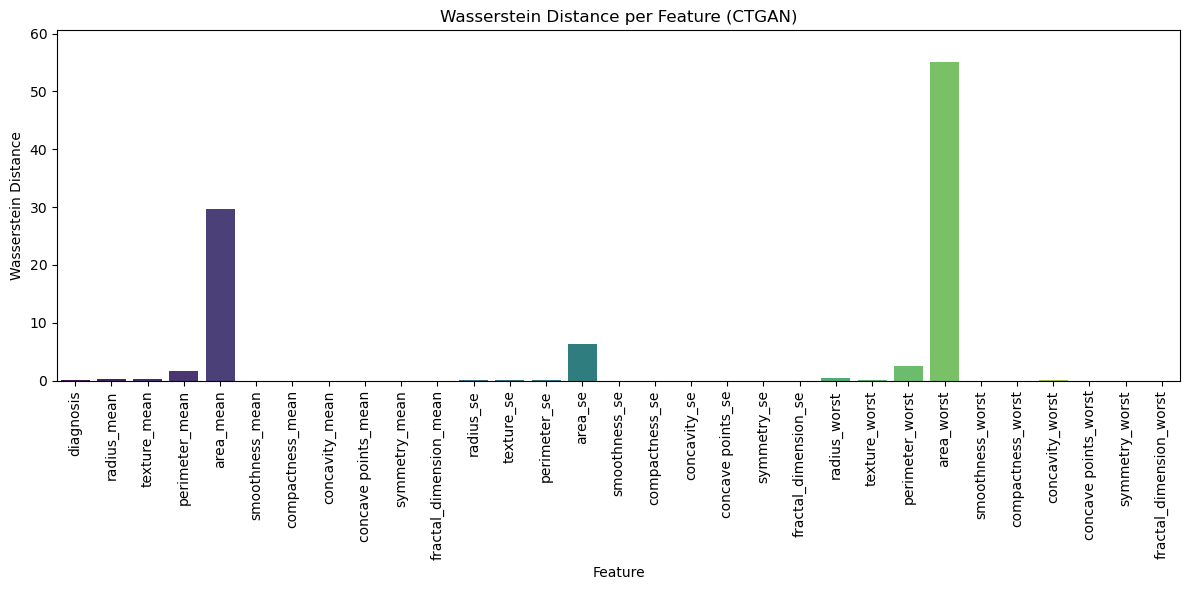

In [32]:
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt


for col in cancer_data.columns:
    dist = wasserstein_distance(cancer_data[col], synthetic_data_copulagan[col])
    print(f'{col}: {dist: .4f}')


# Compute distances
distances = {col: wasserstein_distance(cancer_data[col], synthetic_data_gaussiancopula[col]) 
             for col in cancer_data.columns}
dist_df = pd.DataFrame(list(distances.items()), columns=['Feature', 'Wasserstein Distance'])

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y='Wasserstein Distance', data=dist_df, palette='viridis')

# Format axes
plt.xticks(rotation=90)
plt.title('Wasserstein Distance per Feature (CTGAN)')
plt.tight_layout()

# Adjust y-axis to fit data better
ymin = 0
ymax = dist_df['Wasserstein Distance'].max() * 1.1  # add 10% padding on top
plt.ylim(ymin, ymax)

plt.show()

In [46]:
# ---- usage example ----
results = evaluate_all_metrics(cancer_data, synthetic_data_gaussiancopula, bins="fd")
print(results)
# results.describe()


                    Feature     Type  JS_divergence  JS_distance  \
0                 diagnosis  numeric       0.000269     0.016409   
1             texture_worst  numeric       0.010297     0.101472   
2            concavity_mean  numeric       0.013621     0.116708   
3         compactness_worst  numeric       0.014229     0.119287   
4              texture_mean  numeric       0.014899     0.122060   
5    fractal_dimension_mean  numeric       0.015039     0.122635   
6                texture_se  numeric       0.016604     0.128858   
7          compactness_mean  numeric       0.016822     0.129700   
8            perimeter_mean  numeric       0.016845     0.129787   
9           perimeter_worst  numeric       0.017322     0.131613   
10              radius_mean  numeric       0.018693     0.136721   
11             radius_worst  numeric       0.018777     0.137029   
12            symmetry_mean  numeric       0.018790     0.137076   
13     concave points_worst  numeric       0.019

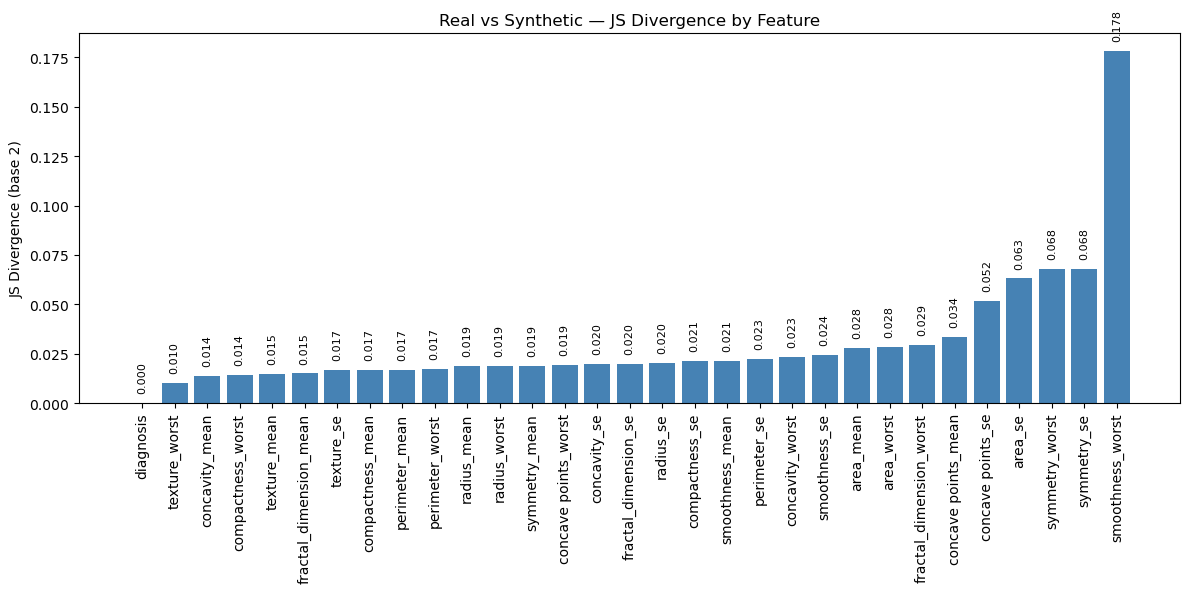

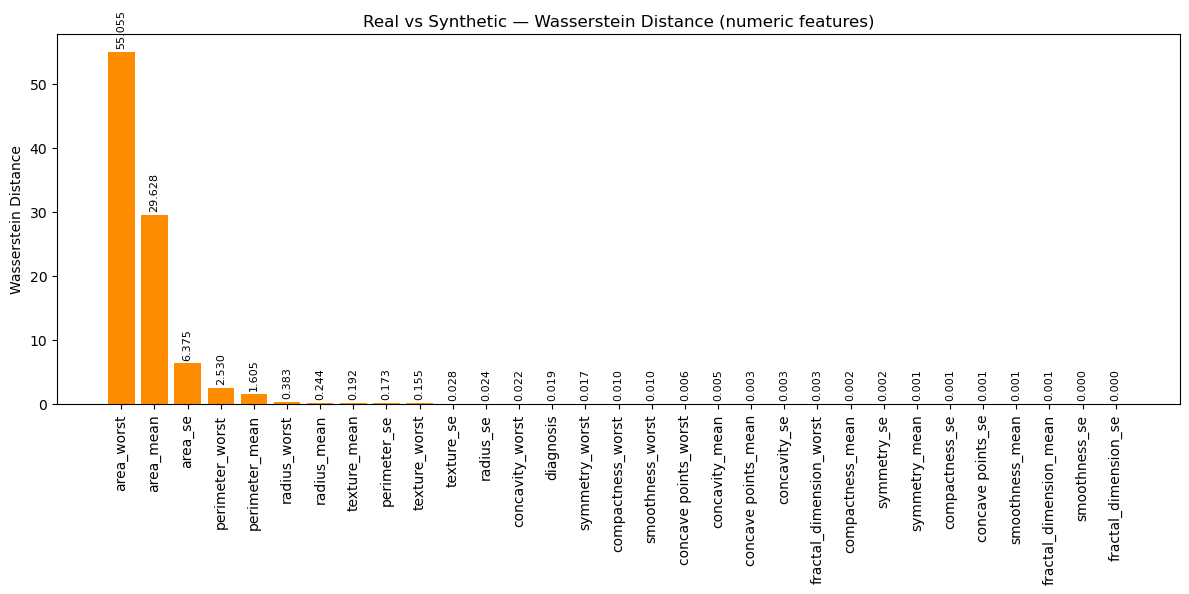

In [47]:
import matplotlib.pyplot as plt

res = evaluate_all_metrics(cancer_data, synthetic_data_gaussiancopula, bins="fd")

# --- JS Divergence by Feature ---
plt.figure(figsize=(12,6))
bars = plt.bar(res["Feature"], res["JS_divergence"], color='steelblue')
plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("Real vs Synthetic — JS Divergence by Feature")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.005,                      # vertical offset
        f"{yval:.3f}", 
        ha='center', va='bottom', fontsize=8, rotation=90
    )

plt.show()


# --- Numeric-only Wasserstein ---
num_res = res[res["Type"] == "numeric"].sort_values("Wasserstein", ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(num_res["Feature"], num_res["Wasserstein"], color='darkorange')
plt.xticks(rotation=90)
plt.ylabel("Wasserstein Distance")
plt.title("Real vs Synthetic — Wasserstein Distance (numeric features)")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + (num_res["Wasserstein"].max() * 0.01),  # small offset based on scale
        f"{yval:.3f}", 
        ha='center', va='bottom', fontsize=8, rotation=90
    )

plt.show()

# TVAE Synthesizer 

The **TVAE (Tabular Variational Autoencoder)** synthesizer is a deep learning–based generative model designed specifically for producing high-quality synthetic **tabular data**. It uses a **variational autoencoder (VAE)** architecture that encodes real data into a lower-dimensional latent space and then decodes samples from that space back into realistic synthetic records. Unlike traditional VAEs, TVAE handles a mix of **continuous and categorical features** by modeling them with appropriate likelihood functions, making it well-suited for datasets like the **Breast Cancer Wisconsin dataset**. During training, TVAE learns both feature distributions and inter-feature dependencies, allowing it to generate synthetic data that closely matches the statistical properties and predictive relationships of the real data while reducing privacy risks and supporting downstream machine-learning tasks.

In [33]:
from sdv.single_table import TVAESynthesizer
tvae = TVAESynthesizer(metadata)
tvae.fit(cancer_data)
synthetic_data_tvae = tvae.sample(1000)
diagnostic_report = run_diagnostic(cancer_data, synthetic_data_tvae, metadata)
quality_report = evaluate_quality(cancer_data, synthetic_data_tvae, metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 31/31 [00:00<00:00, 2714.99it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<?, ?it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 31/31 [00:00<00:00, 614.95it/s]|
Column Shapes Score: 86.12%

(2/2) Evaluating Column Pair Trends: |██████████| 465/465 [00:01<00:00, 246.27it/s]|
Column Pair Trends Score: 90.7%

Overall Score (Average): 88.41%



In [34]:
# Remove target column
X_real = cancer_data.drop(columns=['diagnosis'])
X_synth = synthetic_data_tvae.drop(columns=['diagnosis'])

# Compute Gower distance matrices
gower_real = 1 - gower.gower_matrix(X_real)    # similarity = 1 - distance
gower_synth = 1 - gower.gower_matrix(X_synth)
gower_cross = 1 - gower.gower_matrix(X_real, X_synth)  # cross-set similarity


# Upper triangle indices (exclude diagonal)

real_upper = gower_real[np.triu_indices_from(gower_real, k=1)]
synth_upper = gower_synth[np.triu_indices_from(gower_synth, k=1)]

# Max and average intra-set similarity

max_intra_real = np.max(real_upper)
avg_intra_real = np.mean(real_upper)

max_intra_synth = np.max(synth_upper)
avg_intra_synth = np.mean(synth_upper)

# Flatten the cross-set matrix

cross_flat = gower_cross.flatten()

max_cross = np.max(cross_flat)
avg_cross = np.mean(cross_flat)


print("Intra-set Similarity (Real):")
print(f"Max = {max_intra_real:.4f}, Avg = {avg_intra_real:.4f}\n")

print("Intra-set Similarity (Synthetic):")
print(f"Max = {max_intra_synth:.4f}, Avg = {avg_intra_synth:.4f}\n")

print("Cross-set Similarity (Real vs Synthetic):")
print(f"Max = {max_cross:.4f}, Avg = {avg_cross:.4f}")

Intra-set Similarity (Real):
Max = 0.9809, Avg = 0.8528

Intra-set Similarity (Synthetic):
Max = 0.9529, Avg = 0.8362

Cross-set Similarity (Real vs Synthetic):
Max = 0.9744, Avg = 0.8682


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_tvae.drop(columns=['diagnosis']))

# Cosine similarity
cross_sim = cosine_similarity(real_scaled, synthetic_scaled)
avg_sim = np.mean(cross_sim)
max_sim = np.max(cross_sim)

# MMD (using Gaussian kernel)
def gaussian_kernel(x, y, sigma=1.0):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    x_tile = np.tile(x, (y_size, 1))
    y_tile = np.repeat(y, x_size, axis=0)
    return np.exp(-np.sum((x_tile - y_tile)**2, axis=1) / (2 * dim * sigma**2)).reshape(y_size, x_size)

def compute_mmd(x, y, sigma=1.0):
    k_xx = np.mean(gaussian_kernel(x, x, sigma))
    k_yy = np.mean(gaussian_kernel(y, y, sigma))
    k_xy = np.mean(gaussian_kernel(x, y, sigma))
    return k_xx + k_yy - 2 * k_xy

mmd_score = compute_mmd(real_scaled, synthetic_scaled)

print(f"\n Sample-Level Similarity:")
print(f"Average cosine similarity: {avg_sim:.4f}")
print(f"Maximum cosine similarity: {max_sim:.4f}")
print(f"MMD score: {mmd_score:.4f}")


 Sample-Level Similarity:
Average cosine similarity: 0.0482
Maximum cosine similarity: 0.9504
MMD score: 0.0298


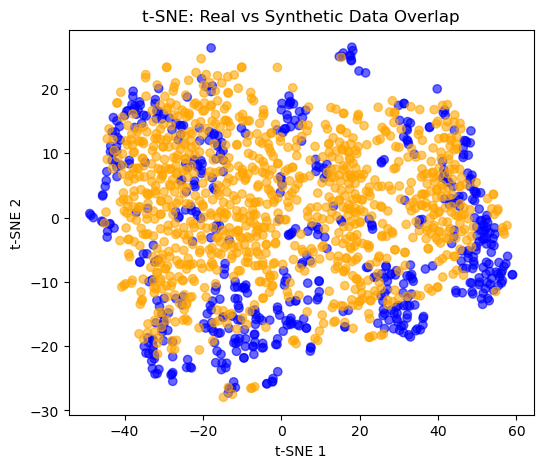

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
combined = np.vstack([real_scaled, synthetic_scaled])
tsne_result = tsne.fit_transform(combined)
labels = ['Real'] * len(real_scaled) + ['Synthetic'] * len(synthetic_scaled)

plt.figure(figsize=(6,5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
            c=['blue' if l == 'Real' else 'orange' for l in labels],
            alpha=0.6, label=None)
plt.title("t-SNE: Real vs Synthetic Data Overlap")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define real and synthetic datasets
real_data = cancer_data
synthetic_data = synthetic_data_tvae

# Split synthetic data (train/test)
X_synth = synthetic_data.drop(['diagnosis'], axis=1)
y_synth = synthetic_data['diagnosis']
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
    X_synth, y_synth, test_size=0.2, random_state=42
)

# Split real data (train/test)
X_real = real_data.drop(['diagnosis'], axis=1)
y_real = real_data['diagnosis']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Scale features using scaler fitted on synthetic training data
scaler = StandardScaler().fit(X_train_synth)
X_train_synth_scaled = scaler.transform(X_train_synth)
X_test_real_scaled = scaler.transform(X_test_real)  # scale real data with same scaler

# Train model on synthetic data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_synth_scaled, y_train_synth)

# Test model on real data
y_pred_real = model.predict(X_test_real_scaled)
y_pred_prob_real = model.predict_proba(X_test_real_scaled)[:, 1]  # probability for class 1

# Evaluate performance
acc = accuracy_score(y_test_real, y_pred_real)
f1 = f1_score(y_test_real, y_pred_real)
auc = roc_auc_score(y_test_real, y_pred_prob_real)

print("Train on Synthetic, Test on Real (TSTR):")
print(f"Accuracy = {acc:.3f}")
print(f"F1 Score = {f1:.3f}")
print(f"AUC = {auc:.3f}")

Train on Synthetic, Test on Real (TSTR):
Accuracy = 0.974
F1 Score = 0.966
AUC = 0.998


In [38]:
# Privacy (Nearest Neighbor Distance)

from sklearn.neighbors import NearestNeighbors

# Standardize using the same scaler
scaler = StandardScaler()
real_scaled = scaler.fit_transform(cancer_data.drop(columns=['diagnosis']))
synthetic_scaled = scaler.transform(synthetic_data_tvae.drop(columns=['diagnosis']))

# Compute Nearest Neighbor Distance
nn = NearestNeighbors(n_neighbors=1).fit(real_scaled)
distances, _ = nn.kneighbors(synthetic_scaled)
avg_nn_dist = np.mean(distances)

print("Privacy Check:")
print(f"Average Nearest Neighbor Distance (Synthetic → Real): {avg_nn_dist:.4f}")

Privacy Check:
Average Nearest Neighbor Distance (Synthetic → Real): 2.7205


diagnosis:  0.1084
radius_mean:  4.4747
texture_mean:  3.2631
perimeter_mean:  6.6542
area_mean:  565.2861
smoothness_mean:  0.0049
compactness_mean:  0.0092
concavity_mean:  0.0131
concave points_mean:  0.0110
symmetry_mean:  0.0080
fractal_dimension_mean:  0.0020
radius_se:  0.0902
texture_se:  0.3234
perimeter_se:  0.5462
area_se:  32.1723
smoothness_se:  0.0017
compactness_se:  0.0090
concavity_se:  0.0046
concave points_se:  0.0030
symmetry_se:  0.0045
fractal_dimension_se:  0.0025
radius_worst:  6.7033
texture_worst:  2.0973
perimeter_worst:  36.3622
area_worst:  413.0021
smoothness_worst:  0.0163
compactness_worst:  0.1027
concavity_worst:  0.1460
concave points_worst:  0.0213
symmetry_worst:  0.0403
fractal_dimension_worst:  0.0106


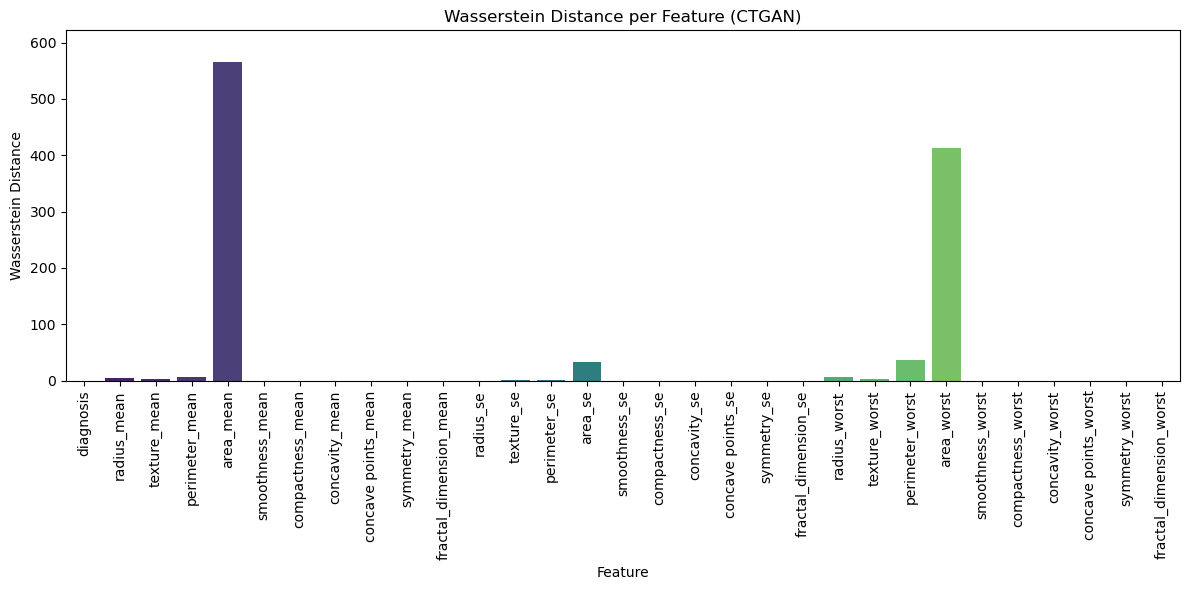

In [39]:
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt


for col in cancer_data.columns:
    dist = wasserstein_distance(cancer_data[col], synthetic_data_copulagan[col])
    print(f'{col}: {dist: .4f}')


# Compute distances
distances = {col: wasserstein_distance(cancer_data[col], synthetic_data_copulagan[col]) 
             for col in cancer_data.columns}
dist_df = pd.DataFrame(list(distances.items()), columns=['Feature', 'Wasserstein Distance'])

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y='Wasserstein Distance', data=dist_df, palette='viridis')

# Format axes
plt.xticks(rotation=90)
plt.title('Wasserstein Distance per Feature (CTGAN)')
plt.tight_layout()

# Adjust y-axis to fit data better
ymin = 0
ymax = dist_df['Wasserstein Distance'].max() * 1.1  # add 10% padding on top
plt.ylim(ymin, ymax)

plt.show()

In [49]:
# ---- usage example ----
results = evaluate_all_metrics(cancer_data, synthetic_data_tvae, bins="fd")
print(results)
# results.describe()

                    Feature     Type  JS_divergence  JS_distance  \
0                 diagnosis  numeric       0.002748     0.052420   
1      concave points_worst  numeric       0.011096     0.105337   
2             texture_worst  numeric       0.021516     0.146684   
3           smoothness_mean  numeric       0.024125     0.155324   
4            concavity_mean  numeric       0.025480     0.159623   
5              radius_worst  numeric       0.029954     0.173072   
6       concave points_mean  numeric       0.039005     0.197496   
7                texture_se  numeric       0.039547     0.198864   
8             symmetry_mean  numeric       0.040204     0.200510   
9              concavity_se  numeric       0.041878     0.204641   
10         smoothness_worst  numeric       0.042341     0.205769   
11         compactness_mean  numeric       0.043821     0.209335   
12        compactness_worst  numeric       0.044540     0.211045   
13   fractal_dimension_mean  numeric       0.045

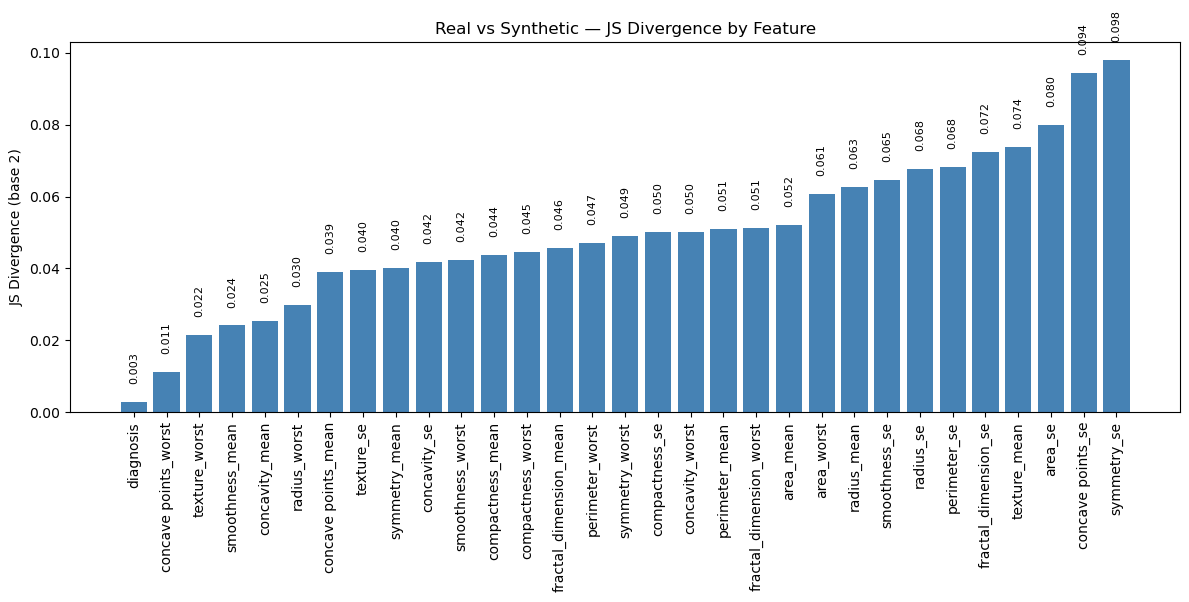

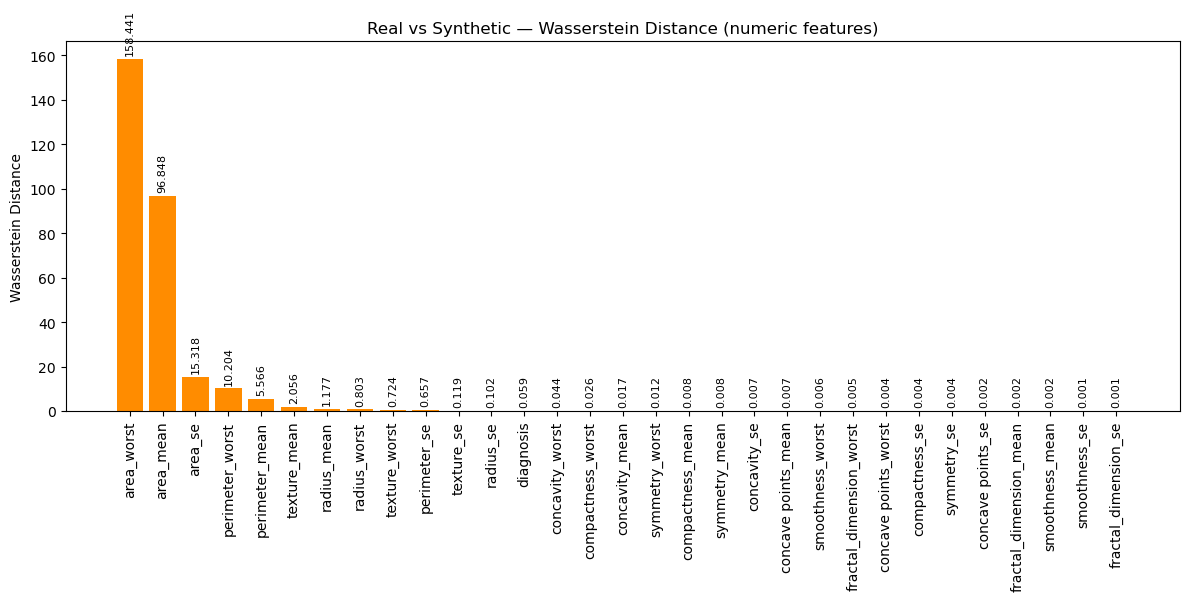

In [51]:
import matplotlib.pyplot as plt

res = evaluate_all_metrics(cancer_data, synthetic_data_tvae, bins="fd")

# --- JS Divergence by Feature ---
plt.figure(figsize=(12,6))
bars = plt.bar(res["Feature"], res["JS_divergence"], color='steelblue')
plt.xticks(rotation=90)
plt.ylabel("JS Divergence (base 2)")
plt.title("Real vs Synthetic — JS Divergence by Feature")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + 0.005,                      # vertical offset
        f"{yval:.3f}", 
        ha='center', va='bottom', fontsize=8, rotation=90
    )

plt.show()


# --- Numeric-only Wasserstein ---
num_res = res[res["Type"] == "numeric"].sort_values("Wasserstein", ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(num_res["Feature"], num_res["Wasserstein"], color='darkorange')
plt.xticks(rotation=90)
plt.ylabel("Wasserstein Distance")
plt.title("Real vs Synthetic — Wasserstein Distance (numeric features)")
plt.tight_layout()

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + (num_res["Wasserstein"].max() * 0.01),  # small offset based on scale
        f"{yval:.3f}", 
        ha='center', va='bottom', fontsize=8, rotation=90
    )

plt.show()